# Kecerdasan Buatan - Klasifikasi Daun Tanaman Herbal

Anggota :
1. Hilmi Fauzi
2. Muhammad Rafli Arnanda

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
import shutil

In [21]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import os
import PIL
from time import time

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten, Dropout, BatchNormalization, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
basedir = '/content/gdrive/My Drive/A.I'
classname = ['Belimbing Wuluh', 'Jambu Biji', 'Jeruk Nipis', 'Kemangi', 'Lidah Buaya', 'Nangka' , 'Pandan', 'Pepaya', 'Seledri', 'Sirih']

In [9]:
for i in classname:
  os.makedirs(basedir +'/test/' + i)
  os.makedirs(basedir +'/train/' + i)
  source = basedir + '/Dataset/' + i
  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  ratio = 0.2

  train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                        [int(len(allFileNames)* (1 - ratio))])
  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, basedir +'/train/' + i)

  for name in test_FileNames:
    shutil.copy(name, basedir +'/test/' + i)

In [22]:
import pathlib
train_path = '/content/gdrive/My Drive/A.I/train'
test_path = '/content/gdrive/My Drive/A.I/test'
data_dir = pathlib.Path(train_path)

In [23]:
img_width = 150
img_height = 150 
batch_size = 32

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print()

val_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

print()

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2800 files belonging to 10 classes.
Using 2240 files for training.

Found 2800 files belonging to 10 classes.
Using 560 files for validation.

Found 700 files belonging to 10 classes.


In [25]:
labels = os.listdir(data_dir)
count = {}
for i in labels:
    count[i] = len(list(data_dir.glob(f'{i}/*.jpg')))

pd.DataFrame(count, index = [0])

,Belimbing Wuluh,Jambu Biji,Jeruk Nipis,Kemangi,Lidah Buaya,Nangka,Pandan,Pepaya,Seledri,Sirih
0,280,280,280,280,280,280,280,280,280,280


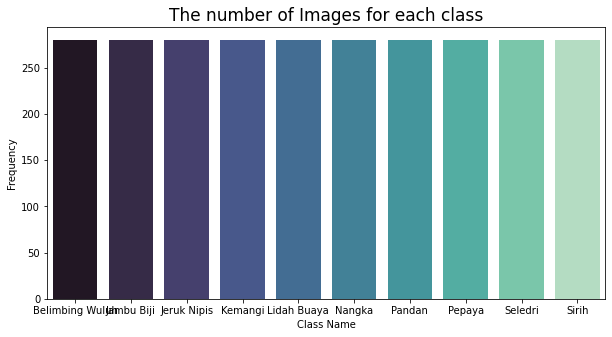

In [26]:
y = [values for values in count.values()]
plt.figure(figsize = (10,5))
sns.barplot(x = labels, y = y, palette = 'mako')
plt.title('The number of Images for each class', fontsize = 17)
plt.xlabel('Class Name')
plt.ylabel('Frequency')
plt.show()

In [27]:
class_names = train_ds.class_names

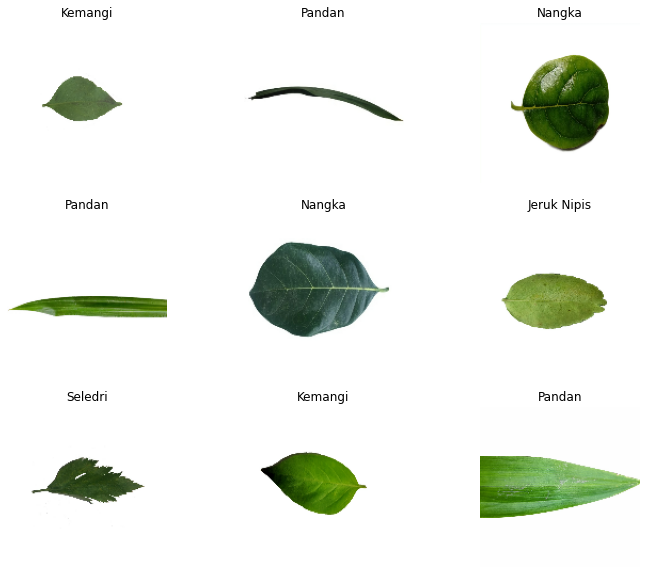

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    break

In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
num_classes = len(class_names)

model1 = Sequential([
           layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
           layers.Conv2D(filters = 16 ,kernel_size = (5, 5), padding='same', activation='relu', name = 'conv1'),
           layers.MaxPooling2D(pool_size = (2,2)),

           layers.Conv2D(filters = 32 ,kernel_size = (5, 5), padding='same', activation='relu', name = 'conv2'),
           layers.MaxPooling2D(pool_size = (2,2)),

           layers.Conv2D(filters = 64 ,kernel_size = (5, 5), padding='same', activation='relu', name = 'conv3'),
           layers.MaxPooling2D(pool_size=(2,2)),

           layers.Flatten(),
           layers.Dense(128, activation='relu'),
           Dropout(0.5),
           layers.Dense(num_classes, activation = 'softmax')
]) 

model1.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate = .0001),
        loss=SparseCategoricalCrossentropy(),
        metrics=['accuracy'])

In [31]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 75, 75, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 37, 37, 64)        5

In [32]:
history_model1 = model1.fit(train_ds, validation_data = val_ds, epochs = 5)

Epoch 1/5
70/70 [==============================] - 123s 2s/step - loss: 2.2598 - accuracy: 0.1835 - val_loss: 2.0515 - val_accuracy: 0.4071
Epoch 2/5
70/70 [==============================] - 102s 1s/step - loss: 1.8825 - accuracy: 0.3393 - val_loss: 1.6216 - val_accuracy: 0.4696
Epoch 3/5
70/70 [==============================] - 103s 1s/step - loss: 1.6029 - accuracy: 0.4397 - val_loss: 1.4388 - val_accuracy: 0.5089
Epoch 4/5
70/70 [==============================] - 103s 1s/step - loss: 1.4491 - accuracy: 0.4848 - val_loss: 1.2584 - val_accuracy: 0.5554
Epoch 5/5
70/70 [==============================] - 101s 1s/step - loss: 1.3577 - accuracy: 0.5063 - val_loss: 1.1933 - val_accuracy: 0.5893


In [33]:
test_loss, test_accuracy = model1.evaluate(test_ds, batch_size=batch_size)

22/22 [==============================] - 12s 471ms/step - loss: 1.2180 - accuracy: 0.5743


In [34]:
print(f'The loss result is {test_loss}')
print(f'The accuracy result is {test_accuracy}')

The loss result is 1.2179511785507202
The accuracy result is 0.5742856860160828


In [41]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(5),
    layers.RandomZoom(0.1),
  ]
)

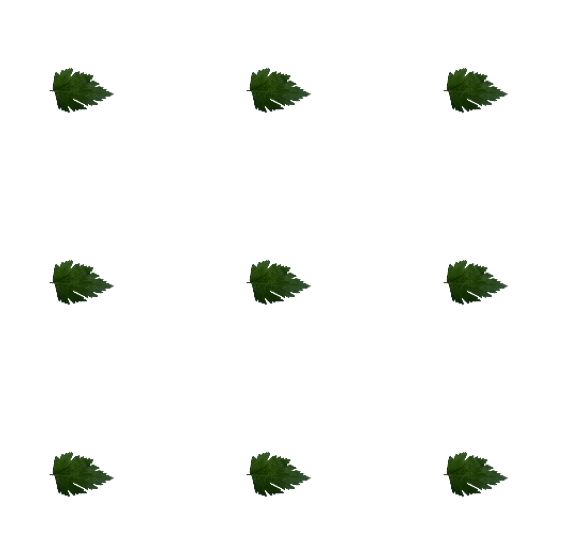

In [42]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [43]:
num_classes = len(class_names)

model2 = Sequential([
           data_augmentation,
           layers.Rescaling(1./255),
    
           layers.Conv2D(filters = 64 ,kernel_size = (5, 5), padding='valid', activation='relu', name = 'conv1'),
           layers.MaxPooling2D(pool_size = (2,2)),

           layers.Conv2D(filters = 32 ,kernel_size = (3, 3), padding='valid', activation='relu', name = 'conv2'),
           layers.MaxPooling2D(pool_size = (2,2)),

           layers.Conv2D(filters = 16 ,kernel_size = (3, 3), padding='valid', activation='relu', name = 'conv3'),
           layers.MaxPooling2D(pool_size=(2,2)),

    
           layers.Flatten(),
           layers.Dense(128, activation='relu'),
           Dropout(0.5),
           layers.Dense(units = num_classes, activation = 'softmax')
]) 



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.0001)

# Compile the model 
model2.compile(
    optimizer= optimizer,
loss=SparseCategoricalCrossentropy(),
         metrics=['accuracy'])

In [44]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 146, 146, 64)      4864      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 71, 71, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                  

In [45]:
history_model2 = model2.fit(train_ds, validation_data = val_ds, epochs = 30)

Epoch 1/30
70/70 [==============================] - 125s 2s/step - loss: 2.2729 - accuracy: 0.1437 - val_loss: 2.1730 - val_accuracy: 0.2804
Epoch 2/30
70/70 [==============================] - 123s 2s/step - loss: 2.0826 - accuracy: 0.2598 - val_loss: 1.8301 - val_accuracy: 0.3536
Epoch 3/30
70/70 [==============================] - 121s 2s/step - loss: 1.8338 - accuracy: 0.3357 - val_loss: 1.6803 - val_accuracy: 0.3875
Epoch 4/30
70/70 [==============================] - 123s 2s/step - loss: 1.7554 - accuracy: 0.3554 - val_loss: 1.5827 - val_accuracy: 0.4375
Epoch 5/30
70/70 [==============================] - 123s 2s/step - loss: 1.6907 - accuracy: 0.3652 - val_loss: 1.5547 - val_accuracy: 0.4232
Epoch 6/30
70/70 [==============================] - 123s 2s/step - loss: 1.6157 - accuracy: 0.4000 - val_loss: 1.5528 - val_accuracy: 0.4268
Epoch 7/30
70/70 [==============================] - 123s 2s/step - loss: 1.5843 - accuracy: 0.4138 - val_loss: 1.5182 - val_accuracy: 0.4482
Epoch 8/30
70

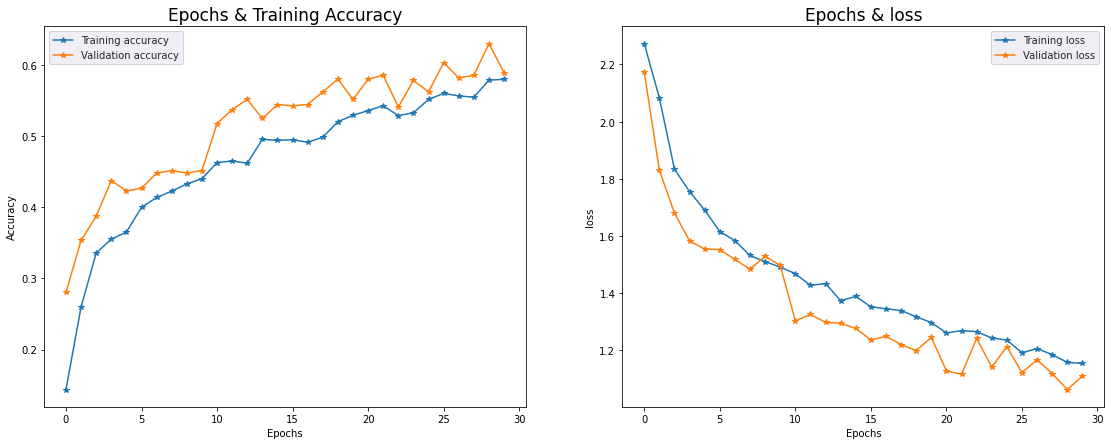

In [46]:
acc = history_model2.history['accuracy']
val_acc = history_model2.history['val_accuracy']

loss=history_model2.history['loss']
val_loss=history_model2.history['val_loss']

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (19,7))
sns.set_style("darkgrid")

ax[0].plot(acc, '*-',label = 'Training accuracy')
ax[0].plot(val_acc, '*-',label = 'Validation accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Epochs & Training Accuracy', fontsize = 17)
ax[0].legend(loc='best')


ax[1].plot(loss, '*-',label = 'Training loss')
ax[1].plot(val_loss, '*-',label = 'Validation loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('loss')
ax[1].set_title('Epochs & loss', fontsize = 17)
ax[1].legend(loc='best')
sns.set_style("darkgrid")

plt.show()

In [47]:
predictions = model2.predict(test_ds)

22/22 [==============================] - 9s 401ms/step


In [48]:
y_pred = np.argmax(predictions, axis=1)

labels = []
for _, label in test_ds:
    labels.append(label)
    
y_true = []
for i in labels:
    for j in i:
        y_true.append(int(j))

print(y_pred[:10])
print(y_true[:10])

[5 4 4 3 9 5 9 0 2 8]
[1, 4, 4, 3, 3, 5, 2, 4, 9, 8]


In [49]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.61      0.59      0.60        70
           1       0.89      0.24      0.38        70
           2       0.44      0.53      0.48        70
           3       0.50      0.26      0.34        70
           4       0.71      0.56      0.62        70
           5       0.52      0.66      0.58        70
           6       0.62      0.81      0.70        70
           7       0.69      0.97      0.81        70
           8       0.44      0.61      0.51        70
           9       0.46      0.41      0.44        70

    accuracy                           0.56       700
   macro avg       0.59      0.56      0.55       700
weighted avg       0.59      0.56      0.55       700

